<a href="https://colab.research.google.com/github/Vasanta2002/sprint_7/blob/main/JDS_SHR_232_guided_project_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BloomTech Data Science

---


# Wrangle ML datasets 
- Explore tabular data for supervised machine learning
- Join relational data for supervised machine learning

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

In [2]:
from glob import glob 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests 
import tarfile
from IPython.display import Image

# I. Wrangle Data

In [3]:
# Download data
def download(url):
    filename = url.split('/')[-1]
    print(f'Downloading {url}')
    r = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(r.content)
    print(f'Downloaded {filename}')

download('https://lambdaschool-ds-instruction.s3.amazonaws.com/datasets%3Ainstacart_2017_05_01.tar.gz')

Downloaded datasets%3Ainstacart_2017_05_01.tar.gz


In [4]:
# # Uncompress data
tarfile.open('datasets%3Ainstacart_2017_05_01.tar.gz').extractall()

In [5]:
# Change directory to where the data was uncompressed
!cd instacart_2017_05_01

In [6]:
# Print the csv filenames
pattern = 'instacart_2017_05_01/*.csv'


for filename in glob(pattern): 
    print(filename)

instacart_2017_05_01/products.csv
instacart_2017_05_01/departments.csv
instacart_2017_05_01/aisles.csv
instacart_2017_05_01/order_products__train.csv
instacart_2017_05_01/order_products__prior.csv
instacart_2017_05_01/orders.csv


**Before you start,** load each of the above `.csv` files into its own DataFrame.

In [7]:
orders = pd.read_csv('instacart_2017_05_01/orders.csv')
order_products_train = pd.read_csv('instacart_2017_05_01/order_products__train.csv')
order_products_prior = pd.read_csv('instacart_2017_05_01/order_products__prior.csv')
products = pd.read_csv('instacart_2017_05_01/products.csv')

In [8]:
Image(url= "https://i.imgur.com/R7c37Yw.png")

## I.a. Warm-up Questions

What information is contained in the column `orders['eval_set']`?

In [9]:
orders['eval_set'].describe()

count     3421083
unique          3
top         prior
freq      3214874
Name: eval_set, dtype: object

In [10]:
orders['eval_set'].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

The first row of `orders['order_id']` is `2539329`. Where can we find the items that were included in that order?

In [11]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [12]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [13]:
mask = (order_products_prior['order_id'] == 2539329)
order_products_prior[mask]

,order_id,product_id,add_to_cart_order,reordered
24076664,2539329,196,1,0
24076665,2539329,14084,2,0
24076666,2539329,12427,3,0
24076667,2539329,26088,4,0
24076668,2539329,26405,5,0


The first row of `order_products__prior['product_id']` is `33120`. What is the name of that product?

In [14]:
mask2 = (products['product_id'] == 33120)
products[mask2]

,product_id,product_name,aisle_id,department_id
33119,33120,Organic Egg Whites,86,16


# Define Our Machine Learning Problem

- We want predict whether or not a customer will purchase a specific item (of our choosing).
- The most commonly ordered product: `'Banana'` (`24852`).
- Our model is going to predict whether or not an order will include a `'Banana'`.

Lets adjust the Kaggle competition classification task from "What products will be ordered?" (multiclass, multilabel classification) to "Will one product be reordered?" (binary classification).

In [15]:
order_products_prior['product_id'].value_counts().head()

24852    472565
13176    379450
21137    264683
21903    241921
47209    213584
Name: product_id, dtype: int64

In [16]:
mask3 = products['product_id'] == 24852
products[mask3]

,product_id,product_name,aisle_id,department_id
24851,24852,Banana,24,4


## I.c. Create Feature Matrix and Target Vector

Our **feature matrix** will be all the `'train'` rows from `orders`.

Our **target vector** will be whether or not each order in `X` contains the item we've chosen above.

In [17]:
train_mask = orders['eval_set'] == 'train'

X = orders[train_mask].copy()
X.drop(columns='eval_set', inplace=True) 

In [18]:
X.shape

(131209, 6)

In [19]:
X.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
10,1187899,1,11,4,8,14.0
25,1492625,2,15,1,11,30.0
49,2196797,5,5,0,11,6.0
74,525192,7,21,2,11,6.0
78,880375,8,4,1,14,10.0


In [25]:
order_products_train['is_banana'] = order_products_train['product_id'] == 24852

In [26]:
banana_orders = order_products_train[order_products_train['is_banana']]['order_id']

In [27]:
X['includes_bananas'] = X['order_id'].isin(banana_orders).astype(int)

In [28]:
X['includes_bananas']

10         0
25         1
49         0
74         0
78         0
          ..
3420838    0
3420862    0
3420924    0
3420933    1
3421082    1
Name: includes_bananas, Length: 131209, dtype: int64

# I.d Feature Engineering

## What features can we engineer? We want to predict, will these customers reorder bananas on their next order?

- Products per order
- Time of day
- Have they reordered bananas before? (Have ordered bananas >= 2 times)
- Other fruit they buy 
- Size of orders (customers with smaller orders on average are less likely to be reordering any particular product on their next order)


- Frequency of banana orders:
    - % of orders 
    - Time between banana orders: Every n days on average
    - Raw count: Total orders, how many times have you ordered bananas?

- Recency of banana orders
    - n days since you ordered banana



Is an order placed before 11:00AM?

In [ ]:
X['morning_order'] =

In [ ]:
X.head()

How many items in the order?

In [ ]:
n_items_per_order = 

Did the user order `'Banana'` in previous orders?

In [ ]:

order_products_prior['is_banana'] = order_products_prior['product_id'] == 24852
banana_orders_id_prior = order_products_prior[order_products_prior['is_banana']]['order_id']


prior_orders = orders[orders['eval_set']=='prior'].copy()
prior_orders['has_banana'] = prior_orders['order_id'].isin(banana_orders_id_prior)
                                                           

prior_banana_user_ids = prior_orders[prior_orders['has_banana']]['user_id'].unique()

X['prior_banana_orders'] = X['user_id'].isin(prior_banana_user_ids).astype(int)

In [ ]:
X.head()

# II. Split Data

In [29]:
target = 'includes_bananas'

y = X[target]

X = X.drop(columns=['order_id', 'user_id', 'order_number', target]) 

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42)

# III. Establish Baseline

In [31]:
print('Baseline accuracy:', y_train.value_counts(normalize=True).max())

Baseline accuracy: 0.8569931502281669


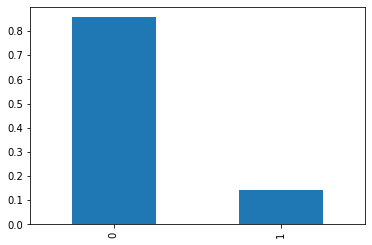

In [32]:
y_train.value_counts(normalize=True).plot(kind='bar')

# IV. Build Model

In [33]:
model_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

model_rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

# V. Check Metrics

In [34]:
print('RF Training Accuracy:', model_rf.score(X_train, y_train))
print('RF Validation Accuracy:', model_rf.score(X_val, y_val)) 

RF Training Accuracy: 0.8579744110053635
RF Validation Accuracy: 0.8570611996036888


In [35]:
print('RF Training Accuracy:', model_rf.score(X_train, y_train))
print('RF Validation Accuracy:', model_rf.score(X_val, y_val))

RF Training Accuracy: 0.8579744110053635
RF Validation Accuracy: 0.8570611996036888
